 # Computer Assignment 5, Phase 1, Neural Networks
 ### The purpose of this project is to implement and train feed forward neural networks.

## First stage, Data review and preprocessing

### Step 1

In [29]:
TRAIN_DATA_FILE_ADDRESS = './Fashion-MNIST/trainData.csv'
TRAIN_LABEL_FILE_ADDRESS = './Fashion-MNIST/trainLabels.csv'
TEST_DATA_FILE_ADDRESS = './Fashion-MNIST/testData.csv'
TEST_LABEL_FILE_ADDRESS = './Fashion-MNIST/testLabels.csv'

In [30]:
from numpy import genfromtxt

train_data_raw = genfromtxt(TRAIN_DATA_FILE_ADDRESS, delimiter=',')
train_label = genfromtxt(TRAIN_LABEL_FILE_ADDRESS, delimiter=',')

train_data_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
test_data_raw = genfromtxt(TEST_DATA_FILE_ADDRESS, delimiter=',')
test_label = genfromtxt(TEST_LABEL_FILE_ADDRESS, delimiter=',')

test_data_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

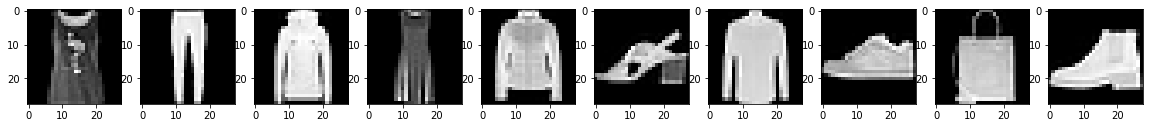

In [530]:
import numpy as np
from matplotlib import pyplot

def show_images(pixels):
    f, axarr = pyplot.subplots(1,10, figsize=(20,20))
    for i in range(len(pixels)):
        axarr[i].imshow(classes[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    pyplot.show() 
    
def choose_record(class_name):
    records = np.where(train_label == class_name)[0]
    record_index = np.random.choice(records, size=1, replace=False)
    return record_index

classes = {}
for i in range(10):
    classes[i] = train_data_raw[choose_record(i)]

show_images(classes)

### Step 2

- Test data : 

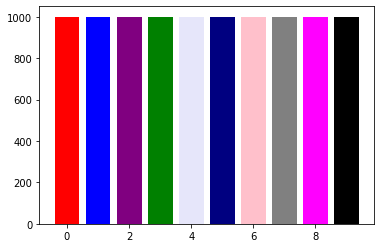

In [32]:
test_occurrences = []
for i in range(len(classes)):
        test_occurrences.append(np.count_nonzero(test_label == i))

pyplot.bar(range(len(test_occurrences)), test_occurrences, color=['red', 'blue', 'purple', 'green', 'lavender', 'navy', 'pink', 'gray', 'fuchsia', 'black'])
pyplot.show()

- Train data :

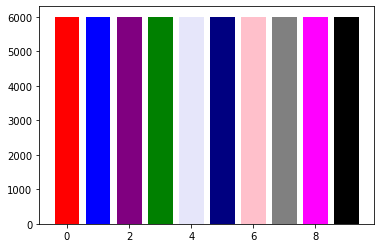

In [33]:
train_occurrences = []
for i in range(len(classes)):
        train_occurrences.append(np.count_nonzero(train_label == i))

pyplot.bar(range(len(train_occurrences)), train_occurrences, color=['red', 'blue', 'purple', 'green', 'lavender', 'navy', 'pink', 'gray', 'fuchsia', 'black'])
pyplot.show()

### Step 3

Normalizing the input will avoid overflow and also if numeric data is not normalized, and the magnitudes of two predictors are far apart, then a change in the value of a neural network weight has far more relative influence on the x-value with larger magnitudes.

In [34]:
train_data = train_data_raw/255

In [35]:
test_data = test_data_raw/255

## Second stage, Complete neural network

### Part 1: Dataloader class

In [36]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
        
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.eye(n_classes)[labels]
        return onehot_vectors
 
    def __shuffle_dataset(self):
        idx = np.random.permutation(len(self.__data))
        self.__data, self.__onehot_labels = self.__data[idx], self.__onehot_labels[idx]
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

### Part 2: Activation functions

#### Linear or Identity Activation Function :
<center>$f(x) = x$</center>

In [37]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

#### ReLU (Rectified Linear Unit) Activation Function :
<center>$f(x) = max(0,x)$</center>

In [38]:
class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        relu_value = np.where(matrix < 0.0, 0.0, matrix)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.where(matrix >= 0, 1.0, 0.0) 
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

####  Leaky ReLU (Rectified Linear Unit) Activation Function :
<center>$x < 0: f(x) = 0.01 \times x$</center>
<center>$x >= 0: f(x) = x$</center>

In [39]:
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.where(matrix <0, self.negative_slope * matrix, matrix)
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.where(matrix >= 0.0, 1.0, self.negative_slope)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

#### Sigmoid or Logistic Activation Function :
<center>$f(x) = {1 \over {1 + e^{-x}}}$</center>

In [226]:
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
#         sigmoid_value = np.matrix(matrix, dtype=float)
        sigmoid_value= 1/(1 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_value = self.__val(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, 1 - sigmoid_value)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

#### Stable softmax :
<center>$p_i = {C \times e^a_i \over {C \times \sum_{k=1}^N e_k^a}}$</center>

In [158]:
class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        matrix = np.matrix(matrix, dtype=float)
        matrix = matrix - np.max(matrix, axis=1)
        e_a = np.exp(matrix)
        p_i= e_a/np.sum(e_a, axis=1)
        softmax_value = p_i
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)

#### Tanh:
<center>$f(x) = tanh(x)$</center>

In [242]:
class Tanh:
    def __init__(self): pass

    def __val(self, matrix):
        matrix = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(matrix)
        return tanh_value

    def derivative(self, matrix):
        matrix = np.matrix(matrix, dtype=float)
        tanh = Tanh()
        tanh_derivative = 1.0 - np.power(np.tanh(matrix), 2)
        return tanh_derivative

    def __call__(self, matrix):
        return self.__val(matrix)

### Part 3: Loss functions

#### Cross Entropy + Softmax :
<center>$L = -\sum_{i} y_i log(p_i)$</center><br>
<center>${\sigma L \over {\sigma o_i}} = p_i - y_i$</center>

In [141]:
class CrossEntropy: 
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        p_i = softmax(true_val)
        log_p_i = np.log(p_i)
        cross_entropy_value = -np.sum(np.multiply(expected_val, log_p_i))
        return cross_entropy_value
        
    def derivative(self, layer_input, expected_val): 
        assert np.shape(layer_input)==np.shape(expected_val)
        softmax = Softmax()
        p = softmax(layer_input)
        y = expected_val
        cross_entropy_derivative = p - y
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

### Part 4: Layer class

#### Uniform distribution :
<center>$a<=x<=b : f(x) = {1 \over {b - a}}$</center><br>
<center>$x<a, x>b : f(x) = 0$</center>


#### Normal distribution :
<center>${1 \over {\sigma \sqrt{2\pi}}} e^{{-1\over 2}{({x- \mu \over \sigma})}^2} $</center>


#### Update weights :

<center>${d_l \over{d_w}} = {d_l \over {d_{out}}} \times {d_{out} \over {d_z}} \times {d_z \over {d_w}}$</center><br>
<center>${d_l \over{d_w}} = {d_l \over {d_{out}}} \times {d_{out} \over {d_z}} \times {x}$</center><br>

<center>${d_l \over{d_b}} = {d_l \over {d_{out}}} \times {d_{out} \over {d_z}} \times {d_z \over {d_b}}$</center><br>
<center>${d_l \over{d_b}} = {d_l \over {d_{out}}} \times {d_{out} \over {d_z}} \times {1}$</center><br>

In [297]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        
        self.__last_input = layer_input
        self.__last_activation_input = np.dot(self.__last_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        d_l_d_out = backprop_tensor
        d_out_d_z = self.__last_activation_derivative
        d_z_d_w = self.__last_input
        d_l_d_z = np.multiply(d_l_d_out, d_out_d_z)
        
        batch_size = self.__last_input.shape[0]
        
        d_l_d_w = np.dot(d_z_d_w.T, d_l_d_z)/batch_size
        d_l_d_b = np.sum(d_l_d_z, axis=0)/batch_size
        
        backprop_tensor = np.dot(d_l_d_z, self.__weight.T)
        
        self.__weight -= lr * d_l_d_w
        self.__bias -= lr * d_l_d_b
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low,high,(dim1, dim2)) * np.sqrt(2 / dim1)
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.random.normal(mean, var, (dim1, dim2)) * np.sqrt(2 / dim1)
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def last_activation_output(self): return self.__last_activation_output
    
    @property
    def activation(self): return self.__activation

### Part 5: FeedForwardNN class

In [534]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None
        
        self.before_last_layer_output = {'train':[], 'test':[]}

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons       
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        cur_layer_input = network_input
        for layer in self.__layers_list :
            cur_layer_output = layer.forward(cur_layer_input)
            cur_layer_input = cur_layer_output
        network_output = cur_layer_output
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch))
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_accuracy)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            if epoch != epochs:
                self.before_last_layer_output['train'] = []
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if epoch != epochs:
                    self.before_last_layer_output['test'] = []
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    def overfit(self, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        last_accuracy = 0
        epochs = 0
        decrease_count=0
        
        while(True):
            epochs += 1
            if print_results: 
                print('Epoch {}:'.format(epochs)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_accuracy)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_test_accuracy, average_test_loss = self.__test(testloader)
                log['test_accuracy'].append(average_test_accuracy)
                log['test_loss'].append(average_test_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_test_accuracy, average_test_loss))
                    
            if average_test_accuracy <= last_accuracy:
                print('In epoch ', epochs, ' overfitteng started.')
                decrease_count += 1
            elif decrease_count != 0:
                decrease_count -= 0
            
            if decrease_count == 3:
                break
            last_accuracy = average_test_accuracy
            
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        network_output = self.forward(x_batch)
        self.before_last_layer_output['train'].extend(self.__layers_list[-2].last_activation_output)
        self.__update_weights(network_output, y_batch)
        labels = self.__get_labels(network_output)
        batch_accuracy = self.__compute_accuracy(labels, y_batch)
        batch_average_loss = self.__loss(network_output, y_batch) / len(y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        network_output = self.forward(x_batch)
        self.before_last_layer_output['test'].extend(self.__layers_list[-2].last_activation_output)
        labels = self.__get_labels(network_output)
        batch_average_loss = self.__loss(network_output, y_batch) / len(y_batch)
        batch_accuracy = self.__compute_accuracy(labels, y_batch)
        return (batch_accuracy, batch_average_loss)
              
    def __get_labels(self, outputs):
#         labels = (np.array(outputs) == np.array(outputs).max(axis=1)[:,None]).astype(int)
        labels = np.zeros_like(outputs)
        labels[np.arange(len(outputs)), outputs.argmax(1)] = 1
        return labels
    
    def __compute_accuracy(self, output, expected_output):
        accuracy = np.sum(np.all(np.equal(output, expected_output), axis=1)) /  len(output)
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        last_layer_input = output
        last_layer_expected_val = y_train
        cur_layer_d = self.__loss.derivative(last_layer_input, last_layer_expected_val)
        for layer in reversed(self.__layers_list):
            cur_layer_d = layer.update_weights(cur_layer_d, self.__lr)
        return
    
    def get_labels(self, outputs):
        return self.__get_labels(outputs)

## Third stage, Data classification

### Firat step

In [265]:
def find_best_learning_rate(batch_size, train_epochs, activation_func, loss_func, initial_weight):
    INPUT_SHAPE = train_data.shape[1]
    max_train_accuracy = 0
    best_train_lr = 0
    max_test_accuracy = 0
    best_test_lr = 0
    for lr in np.arange(0.05, 0.4, 0.05):
        TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=batch_size, shuffle=True)
        TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=batch_size, shuffle=True)
        network = FeedForwardNN(INPUT_SHAPE)
        network.add_layer(n_neurons=20, activation=activation_func, initial_weight=initial_weight)
        network.add_layer(n_neurons=10, activation=activation_func, initial_weight=initial_weight)
        network.set_training_param(loss=loss_func, lr=lr)
        log = network.fit(train_epochs, TRAINLOADER, TESTLOADER)
        if max_train_accuracy < log['train_accuracy'][-1] : 
            max_train_accuracy = log['train_accuracy'][-1]
            best_train_lr = lr
        if max_test_accuracy < log['test_accuracy'][-1] : 
            max_test_accuracy = log['test_accuracy'][-1]
            best_test_lr = lr
        print('--------------lr = ', lr)
        print('--------------train accuracy = ', log['train_accuracy'][-1])
        print('--------------test accuracy = ', log['test_accuracy'][-1])
        
    print('-----------------------------------------------------------------------------')
    print('best train lr = ', best_train_lr)
    print('best train accuracy = ', max_train_accuracy)
    
    print('-----------------------------------------------------------------------------')
    print('best test lr = ', best_test_lr)
    print('best test accuracy = ', max_test_accuracy)
    
    return best_train_lr, best_test_lr
    
    

In [266]:
best_train_lr, best_test_lr = find_best_learning_rate(32, 30, Relu(), CrossEntropy(), 'uniform')

Epoch 1:
	Train: Average Accuracy: 0.6887833333333333	Average Loss: 0.8592964488442169
	Test: Average Accuracy: 0.8144968051118211	Average Loss: 0.5243326298391384
Epoch 2:
	Train: Average Accuracy: 0.8298166666666666	Average Loss: 0.47999530600962087
	Test: Average Accuracy: 0.817991214057508	Average Loss: 0.5026204955916522
Epoch 3:
	Train: Average Accuracy: 0.84655	Average Loss: 0.4308983776210836
	Test: Average Accuracy: 0.8413538338658147	Average Loss: 0.44331427484464725
Epoch 4:
	Train: Average Accuracy: 0.8561666666666666	Average Loss: 0.40285231781449843
	Test: Average Accuracy: 0.8426517571884984	Average Loss: 0.44570352699613264
Epoch 5:
	Train: Average Accuracy: 0.8611333333333333	Average Loss: 0.38635621898083977
	Test: Average Accuracy: 0.8531349840255591	Average Loss: 0.4192512806071814
Epoch 6:
	Train: Average Accuracy: 0.86535	Average Loss: 0.37438927227321017
	Test: Average Accuracy: 0.8525359424920128	Average Loss: 0.4069842190463851
Epoch 7:
	Train: Average Accuracy

	Train: Average Accuracy: 0.8914666666666666	Average Loss: 0.2960842296787739
	Test: Average Accuracy: 0.8656150159744409	Average Loss: 0.3791674830042226
Epoch 23:
	Train: Average Accuracy: 0.89215	Average Loss: 0.29426268865804545
	Test: Average Accuracy: 0.8647164536741214	Average Loss: 0.38100057180950436
Epoch 24:
	Train: Average Accuracy: 0.89235	Average Loss: 0.29223582748303645
	Test: Average Accuracy: 0.8592252396166135	Average Loss: 0.3970301226282543
Epoch 25:
	Train: Average Accuracy: 0.8926833333333334	Average Loss: 0.2902796041170709
	Test: Average Accuracy: 0.8664137380191693	Average Loss: 0.38062841999914926
Epoch 26:
	Train: Average Accuracy: 0.8948333333333334	Average Loss: 0.2870946584712919
	Test: Average Accuracy: 0.862120607028754	Average Loss: 0.3928261707219105
Epoch 27:
	Train: Average Accuracy: 0.8946166666666666	Average Loss: 0.28676038288692063
	Test: Average Accuracy: 0.8660143769968051	Average Loss: 0.3849527507977881
Epoch 28:
	Train: Average Accuracy: 0.

	Train: Average Accuracy: 0.8791833333333333	Average Loss: 0.3282846204065753
	Test: Average Accuracy: 0.8595247603833865	Average Loss: 0.4100172215472151
Epoch 13:
	Train: Average Accuracy: 0.8801666666666667	Average Loss: 0.3251486992084825
	Test: Average Accuracy: 0.8668130990415336	Average Loss: 0.3942965610762339
Epoch 14:
	Train: Average Accuracy: 0.8805333333333333	Average Loss: 0.32203052408557675
	Test: Average Accuracy: 0.8560303514376997	Average Loss: 0.42494717477989935
Epoch 15:
	Train: Average Accuracy: 0.8835333333333333	Average Loss: 0.31587842847534986
	Test: Average Accuracy: 0.8581269968051118	Average Loss: 0.4177169946349862
Epoch 16:
	Train: Average Accuracy: 0.8830833333333333	Average Loss: 0.31658104454880776
	Test: Average Accuracy: 0.8601238019169329	Average Loss: 0.4031116692729593
Epoch 17:
	Train: Average Accuracy: 0.88365	Average Loss: 0.31411523733666685
	Test: Average Accuracy: 0.858426517571885	Average Loss: 0.4103406553888377
Epoch 18:
	Train: Average A

	Train: Average Accuracy: 0.8275833333333333	Average Loss: 0.48010192509697386
	Test: Average Accuracy: 0.8293730031948882	Average Loss: 0.4917697836888293
Epoch 3:
	Train: Average Accuracy: 0.84415	Average Loss: 0.4335726741706704
	Test: Average Accuracy: 0.8338658146964856	Average Loss: 0.4813083805351093
Epoch 4:
	Train: Average Accuracy: 0.8524666666666667	Average Loss: 0.4115081722462824
	Test: Average Accuracy: 0.8486421725239617	Average Loss: 0.4290880811976226
Epoch 5:
	Train: Average Accuracy: 0.8571833333333333	Average Loss: 0.3935963664842661
	Test: Average Accuracy: 0.8568290734824281	Average Loss: 0.413801814570984
Epoch 6:
	Train: Average Accuracy: 0.8601666666666666	Average Loss: 0.38538613634006436
	Test: Average Accuracy: 0.8426517571884984	Average Loss: 0.46232876425170605
Epoch 7:
	Train: Average Accuracy: 0.8647166666666667	Average Loss: 0.3754848391375543
	Test: Average Accuracy: 0.8415535143769968	Average Loss: 0.4367184634164056
Epoch 8:
	Train: Average Accuracy:

	Train: Average Accuracy: 0.8684	Average Loss: 0.5505766843473231
	Test: Average Accuracy: 0.8286741214057508	Average Loss: 0.6611816310941057
Epoch 24:
	Train: Average Accuracy: 0.8686	Average Loss: 0.5459893210381046
	Test: Average Accuracy: 0.8460463258785943	Average Loss: 0.6486702399091893
Epoch 25:
	Train: Average Accuracy: 0.86905	Average Loss: 0.5467010739777226
	Test: Average Accuracy: 0.8372603833865815	Average Loss: 0.6360224022635127
Epoch 26:
	Train: Average Accuracy: 0.8685166666666667	Average Loss: 0.5451271374525074
	Test: Average Accuracy: 0.8490415335463258	Average Loss: 0.65431575264688
Epoch 27:
	Train: Average Accuracy: 0.8698	Average Loss: 0.5419431416469981
	Test: Average Accuracy: 0.8485423322683706	Average Loss: 0.6651260059912568
Epoch 28:
	Train: Average Accuracy: 0.87135	Average Loss: 0.5392903316698714
	Test: Average Accuracy: 0.8580271565495208	Average Loss: 0.6349338471205168
Epoch 29:
	Train: Average Accuracy: 0.8717833333333334	Average Loss: 0.540082693

### Second step

Very small learning rates cause the convergence process to slow down and the network to converge later. Also, very large learning rates cause the weights to change too much each time, which may reduce accuracy.

$lr = lr \times 10$

In [267]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=Relu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=Relu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=10*best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', 10*best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.10043333333333333	Average Loss: 2.302311295465913
	Test: Average Accuracy: 0.09994009584664537	Average Loss: 2.302585092994046
Epoch 2:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.10013977635782748	Average Loss: 2.302585092994046
Epoch 3:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.10023961661341853	Average Loss: 2.302585092994046
Epoch 4:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.10003993610223642	Average Loss: 2.302585092994046
Epoch 5:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.09984025559105432	Average Loss: 2.302585092994046
Epoch 6:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 0.10013977635782748	Average Loss: 2.302585092994046
Epoch 7:
	Train: Average Accuracy: 0.1	Average Loss: 2.302585092994046
	Test: Average Accuracy: 

$lr = lr \times 0.1$

In [269]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=Relu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=Relu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=0.1*best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', 0.1*best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.47458333333333336	Average Loss: 1.4021316819548568
	Test: Average Accuracy: 0.6750199680511182	Average Loss: 0.8267452723899054
Epoch 2:
	Train: Average Accuracy: 0.73535	Average Loss: 0.7194148306477249
	Test: Average Accuracy: 0.762879392971246	Average Loss: 0.6676408923033119
Epoch 3:
	Train: Average Accuracy: 0.7891	Average Loss: 0.6038318183201038
	Test: Average Accuracy: 0.794129392971246	Average Loss: 0.5873033245079596
Epoch 4:
	Train: Average Accuracy: 0.81385	Average Loss: 0.5399526540456963
	Test: Average Accuracy: 0.8058107028753994	Average Loss: 0.5495301489558422
Epoch 5:
	Train: Average Accuracy: 0.82815	Average Loss: 0.5008973474548734
	Test: Average Accuracy: 0.8130990415335463	Average Loss: 0.5324868460704361
Epoch 6:
	Train: Average Accuracy: 0.8355666666666667	Average Loss: 0.4779934772749928
	Test: Average Accuracy: 0.8282747603833865	Average Loss: 0.49547263476387515
Epoch 7:
	Train: Average Accuracy: 0.8398333333333333	Average

### Third step

Sigmoid and hyperbolic tangent are differentiable. But their problem is their gradient goes to zero when magnitude of z becomes large. So activation function output gets saturated and doesn’t change. Updates of weights and biases get very small for one layer. Therefor next layers will be delayed so. This is known as vanishing gradient problem. Neural networks with more layer will suffer this problem more. ReLU activation function resolve this issue because its gradient doesn’t go to zero when magnitude of z increases. 

- Leaky Relu

In [271]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=LeakyRelu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.7497	Average Loss: 0.6785370666535004
	Test: Average Accuracy: 0.8147963258785943	Average Loss: 0.5129912168718808
Epoch 2:
	Train: Average Accuracy: 0.8397666666666667	Average Loss: 0.441196002543757
	Test: Average Accuracy: 0.8323682108626198	Average Loss: 0.46515249485481064
Epoch 3:
	Train: Average Accuracy: 0.8528166666666667	Average Loss: 0.4032034862643036
	Test: Average Accuracy: 0.8477436102236422	Average Loss: 0.4236957415314386
Epoch 4:
	Train: Average Accuracy: 0.8606166666666667	Average Loss: 0.3825628801505747
	Test: Average Accuracy: 0.8524361022364217	Average Loss: 0.4078756940346915
Epoch 5:
	Train: Average Accuracy: 0.8664166666666666	Average Loss: 0.36837120236818816
	Test: Average Accuracy: 0.8523362619808307	Average Loss: 0.42156400077107575
Epoch 6:
	Train: Average Accuracy: 0.8705166666666667	Average Loss: 0.3564061992182332
	Test: Average Accuracy: 0.8468450479233227	Average Loss: 0.4294124811329415
Epoch 7:
	Train: Average A

- Tanh

In [272]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=Tanh(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=Tanh(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.0011333333333333334	Average Loss: 1.3304650752135063
	Test: Average Accuracy: 0.0	Average Loss: 1.1939284231678993
Epoch 2:
	Train: Average Accuracy: 0.0	Average Loss: 1.1618006385277437
	Test: Average Accuracy: 0.0	Average Loss: 1.1614449127240511
Epoch 3:
	Train: Average Accuracy: 0.0	Average Loss: 1.1360338023386682
	Test: Average Accuracy: 0.0	Average Loss: 1.1634513908888946
Epoch 4:
	Train: Average Accuracy: 0.0	Average Loss: 1.1189005440819115
	Test: Average Accuracy: 0.0	Average Loss: 1.131656636201532
Epoch 5:
	Train: Average Accuracy: 0.0	Average Loss: 1.1025547215688374
	Test: Average Accuracy: 0.0	Average Loss: 1.1240980514845247
Epoch 6:
	Train: Average Accuracy: 0.0	Average Loss: 1.0941085090378113
	Test: Average Accuracy: 0.0	Average Loss: 1.1167062347678556
Epoch 7:
	Train: Average Accuracy: 0.0	Average Loss: 1.0887136435289813
	Test: Average Accuracy: 0.0	Average Loss: 1.1148135486813746
Epoch 8:
	Train: Average Accuracy: 0.0	Averag

- Sigmoid

In [273]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=Sigmoid(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=Sigmoid(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.03455	Average Loss: 2.1545437102589795
	Test: Average Accuracy: 0.0	Average Loss: 1.9709941302040528
Epoch 2:
	Train: Average Accuracy: 0.0	Average Loss: 1.9289693115833457
	Test: Average Accuracy: 0.0	Average Loss: 1.9065317608168322
Epoch 3:
	Train: Average Accuracy: 0.0	Average Loss: 1.8886539076597026
	Test: Average Accuracy: 0.0	Average Loss: 1.8760133949256828
Epoch 4:
	Train: Average Accuracy: 0.0	Average Loss: 1.8636645540403782
	Test: Average Accuracy: 0.0	Average Loss: 1.855788356517445
Epoch 5:
	Train: Average Accuracy: 0.0	Average Loss: 1.8454351886937685
	Test: Average Accuracy: 0.0	Average Loss: 1.8374464547803628
Epoch 6:
	Train: Average Accuracy: 0.0	Average Loss: 1.815185481122954
	Test: Average Accuracy: 0.0	Average Loss: 1.7972083520051316
Epoch 7:
	Train: Average Accuracy: 0.0	Average Loss: 1.7780617194179194
	Test: Average Accuracy: 0.0	Average Loss: 1.7684949789545876
Epoch 8:
	Train: Average Accuracy: 0.0	Average Loss: 1.75511

### Fourth step

Using a batch, first, saves RAM and also causes the results of a batch of data to affect the rest of the data.
The use of very small batches causes the personal characteristics of each batch that cannot be considered relevant to the whole data to affect the weights and ultimately the overall result.

- Batch size = 16

In [274]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=16, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=16, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=LeakyRelu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.7809	Average Loss: 0.6005643976849351
	Test: Average Accuracy: 0.8277	Average Loss: 0.48170261052451113
Epoch 2:
	Train: Average Accuracy: 0.8423166666666667	Average Loss: 0.4350340709554417
	Test: Average Accuracy: 0.821	Average Loss: 0.4802427130779374
Epoch 3:
	Train: Average Accuracy: 0.8538833333333333	Average Loss: 0.40079579353746836
	Test: Average Accuracy: 0.8319	Average Loss: 0.46154213390707927
Epoch 4:
	Train: Average Accuracy: 0.8599	Average Loss: 0.38298312717503125
	Test: Average Accuracy: 0.8468	Average Loss: 0.4281001199202341
Epoch 5:
	Train: Average Accuracy: 0.8639333333333333	Average Loss: 0.3694404466939025
	Test: Average Accuracy: 0.8534	Average Loss: 0.4179396106423812
Epoch 6:
	Train: Average Accuracy: 0.8673	Average Loss: 0.3597088438427866
	Test: Average Accuracy: 0.857	Average Loss: 0.40801509956410853
Epoch 7:
	Train: Average Accuracy: 0.8704666666666667	Average Loss: 0.35145581071831483
	Test: Average Accuracy: 0.8559	A

- batch size = 128

In [275]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=128, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=128, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=LeakyRelu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(30, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.6183424395877755	Average Loss: 1.0186315872408298
	Test: Average Accuracy: 0.7616693037974683	Average Loss: 0.6660854270773894
Epoch 2:
	Train: Average Accuracy: 0.8000843994314143	Average Loss: 0.5659250250828203
	Test: Average Accuracy: 0.8031052215189873	Average Loss: 0.5442775973332199
Epoch 3:
	Train: Average Accuracy: 0.8298518567874911	Average Loss: 0.4874624036892202
	Test: Average Accuracy: 0.7957871835443038	Average Loss: 0.5757871753978534
Epoch 4:
	Train: Average Accuracy: 0.8406072316986497	Average Loss: 0.4514583038631255
	Test: Average Accuracy: 0.7946993670886076	Average Loss: 0.551527778004273
Epoch 5:
	Train: Average Accuracy: 0.8491526741293532	Average Loss: 0.4285725165925455
	Test: Average Accuracy: 0.8368275316455697	Average Loss: 0.4464053587627448
Epoch 6:
	Train: Average Accuracy: 0.8531283315565032	Average Loss: 0.41375688455949056
	Test: Average Accuracy: 0.8403876582278481	Average Loss: 0.443508911575907
Epoch 7:
	Train: 

### Fifth Step

We train our network for multiple epochs because in each epoch, we learn more about our training data and its features. In each epoch, our model’s accuracy gets better and better and with this learnings, it achieves good accuracy on test data because it learns points in data for classification. 

In [535]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=True)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=20, activation=LeakyRelu(), initial_weight='uniform')
network.add_layer(n_neurons=10, activation=LeakyRelu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.overfit(TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.7531666666666667	Average Loss: 0.6715846879477562
	Test: Average Accuracy: 0.8163937699680511	Average Loss: 0.5010985063007688
Epoch 2:
	Train: Average Accuracy: 0.84055	Average Loss: 0.4408894719999267
	Test: Average Accuracy: 0.8374600638977636	Average Loss: 0.45786111772081417
Epoch 3:
	Train: Average Accuracy: 0.8536666666666667	Average Loss: 0.40354908049317323
	Test: Average Accuracy: 0.8425519169329073	Average Loss: 0.4521982104550254
Epoch 4:
	Train: Average Accuracy: 0.8603166666666666	Average Loss: 0.38550769419750025
	Test: Average Accuracy: 0.84185303514377	Average Loss: 0.44319800574722745
In epoch  4  overfitteng started.
Epoch 5:
	Train: Average Accuracy: 0.86435	Average Loss: 0.3731987258524499
	Test: Average Accuracy: 0.8498402555910544	Average Loss: 0.42490295128338107
Epoch 6:
	Train: Average Accuracy: 0.8672666666666666	Average Loss: 0.3626528228922924
	Test: Average Accuracy: 0.856729233226837	Average Loss: 0.4068349940772007
Ep

In [536]:
import matplotlib.pyplot as plt
def plot_metrics(result):   
        fig, (ax1, ax2) = plt.subplots(2)
        fig.set_figheight(10)
        fig.set_figwidth(12)
        fig.tight_layout(pad=5.0)

        metric = 'Accuracy'
        ax1.plot(range(len(result['train_accuracy'])), result['train_accuracy'], result['test_accuracy'])
        ax1.set_title(metric)
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'])
        
        metric = 'Loss'
        ax2.plot(range(len(result['train_loss'])), result['train_loss'], result['test_loss'])
        ax2.set_title(metric)
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'])
        
        fig.show()

<ipython-input-536-d92c9ea47704>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


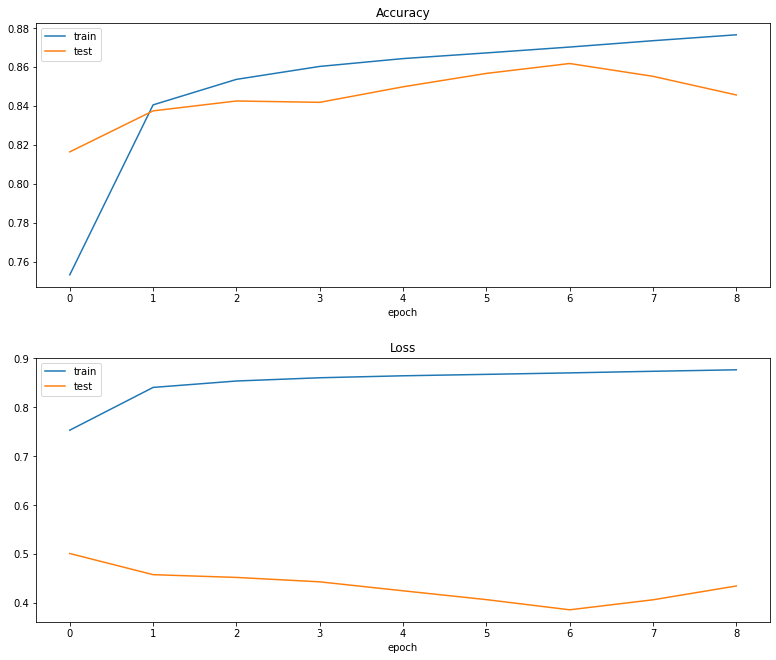

In [537]:
plot_metrics(log)

## Fourth stage, Data mapping with reduced dimension

In [511]:
INPUT_SHAPE = train_data.shape[1]
TRAINLOADER = Dataloader(data=train_data, labels=train_label.astype(int), n_classes=10, batch_size=32, shuffle=False)
TESTLOADER = Dataloader(data=test_data, labels=test_label.astype(int), n_classes=10, batch_size=32, shuffle=False)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons=764, activation=LeakyRelu(), initial_weight='uniform')
network.add_layer(n_neurons=2, activation=LeakyRelu(), initial_weight="uniform")
network.add_layer(n_neurons=10, activation=LeakyRelu(), initial_weight="uniform")
network.set_training_param(loss=CrossEntropy(), lr=best_train_lr)
log = network.fit(3, TRAINLOADER, TESTLOADER)
print('--------------lr = ', best_train_lr)
print('--------------train accuracy = ', log['train_accuracy'][-1])
print('--------------test accuracy = ', log['test_accuracy'][-1])

Epoch 1:
	Train: Average Accuracy: 0.4681666666666667	Average Loss: 1.3107638395059853
	Test: Average Accuracy: 0.6393769968051118	Average Loss: 0.9116701110916583
Epoch 2:
	Train: Average Accuracy: 0.6740833333333334	Average Loss: 0.8138883471297226
	Test: Average Accuracy: 0.7160543130990416	Average Loss: 0.7747640392195265
Epoch 3:
	Train: Average Accuracy: 0.7722666666666667	Average Loss: 0.6859397927338216
	Test: Average Accuracy: 0.7655750798722045	Average Loss: 0.6658514006129201
--------------lr =  0.1
--------------train accuracy =  0.7722666666666667
--------------test accuracy =  0.7655750798722045


In [512]:
before_last_layer_output = network.before_last_layer_output
train_out = np.matrix(before_last_layer_output['train']).T
train_out_x = train_out[0].tolist()[0]
train_out_y = train_out[1].tolist()[0]

test_out = np.matrix(before_last_layer_output['test']).T
test_out_x = test_out[0].tolist()[0]
test_out_y = test_out[1].tolist()[0]

In [527]:
def plot_result(x, y, lebel):
    colors = ['blue', 'red', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'purple']
    for i in range(10000):
        plt.plot(x[i], y[i], marker="o", linestyle="", color=colors[lebel[i]])
    

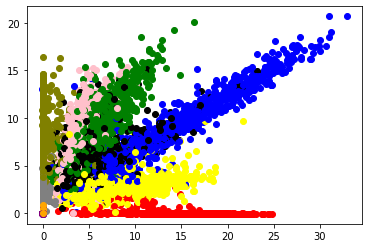

In [528]:
plot_result(train_out_x, train_out_y, train_label.astype(int))

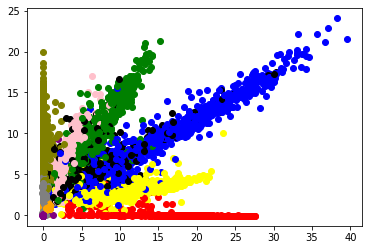

In [529]:
plot_result(test_out_x, test_out_y, test_label.astype(int))

As we see in plot, Red class separated from others very good because it is representative of pants and this clothes is very far from other classes in shape. Yellow class gets closer to other classes because it’s for top of body but because of it’s length, it is separated from other classes. 
Class blue, green, black and pink has a lot conflicts. This colors are representative for shirts and they are not separable from each other. We have problems to detect this types differences. 
Class purple, orange and grey are close to each other and hard to separate. As we seen their examples, they are different kind of shoes and because of that classification for this classes is hard too.
Olive class is separated from other classes because it’s representative for bag class that is different from other products. 
Performance of our network is some how good because it reduces features from 764 to 2. By 2 features, this separations are good enough.
For better detections, one solution can be increase features(Middle layer neurons) to model differences better.